In [478]:
'''
Here are some preliminary imports. We'll need more.
Feel free to install and import any packages you'd like.
'''
import requests
import os
import json
import numpy as np
import pandas as pd

# Additional Libraries
import config #to pull API secret key
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns

# x axis ticks
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [479]:
'''
Let's retrieve all issues in the Apache Airflow OSS project using the github api. 
Insert your username below (in two places).

You should end up with about 20k issues, including ones that date back to 2015 when the project was created.
'''
def get_issues_from_api():
    session = requests.Session()
    url = "https://api.github.com/repos/apache/airflow/issues?state=all"
    response = session.get(
        url,
        auth=(
            "AmirZahre", # your github username
            config.api_secret
        ),
    )
    yield response.json()

    page=2
    while 'next' in response.links:
        response = session.get(
            url,
            auth=(
                "AmirZahre", # your github username
                config.api_secret
            ),
            params={"page": page}
        )
        page += 1
        yield response.json()
        

def get_all_issues(cache_path="airflow_issues.feather"):
    if os.path.exists(cache_path):
        print("retrieving issues from cache")
        df = pd.read_feather(cache_path)
    else:
        print("retrieving issues from API")
        df_shards = []
        for i, page in enumerate(get_issues_from_api()):
            print(f"retrieving page {i}")
            if not page:
                print(f"No issues found on page {i}: {page}")
                continue
            page_df = pd.DataFrame(page)
            df_shards.append(page_df)
        df = pd.concat(df_shards).reset_index()
        print(f"Saving results to {cache_path}")
        df.to_feather(cache_path)
    return df


In [480]:
df = get_all_issues()

retrieving issues from cache


In [481]:
pd.set_option('display.max_columns',None)
df.head()

,index,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,user,labels,state,locked,assignee,assignees,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,draft,pull_request,body,reactions,timeline_url,performed_via_github_app
0,0,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20767,1096939225,PR_kwDOAgUK284wsGiW,20767,Rename amazon EMR hook name,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': 'f89500', 'default': False, 'descri...",closed,False,None,[],None,3,2022-01-08T14:15:31Z,2022-01-08T15:26:11Z,2022-01-08T15:26:09Z,CONTRIBUTOR,None,False,{'diff_url': 'https://github.com/apache/airflo...,Renamed emr hook from Elastic MapReduce to Ama...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
1,1,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/issues/20766,1096938561,I_kwDOAgUK285BYfRB,20766,Status of testing Providers that were prepared...,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': '5319e7', 'default': False, 'descri...",open,False,None,[],None,0,2022-01-08T14:12:48Z,2022-01-08T14:12:48Z,None,MEMBER,None,None,None,### Body\n\nI have a kind request for all the ...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
2,2,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20765,1096903757,PR_kwDOAgUK284wsBH7,20765,Add documentation for an ad-hoc release of 2 p...,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': 'd4c5f9', 'default': False, 'descri...",closed,False,None,[],None,1,2022-01-08T11:24:41Z,2022-01-08T13:59:11Z,2022-01-08T13:59:11Z,MEMBER,None,False,{'diff_url': 'https://github.com/apache/airflo...,<!--\r\nThank you for contributing! Please mak...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
3,3,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20764,1096847036,PR_kwDOAgUK284wr3Zo,20764,Update metric name in documentation,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': '0030b5', 'default': False, 'descri...",open,False,None,[],None,1,2022-01-08T06:15:11Z,2022-01-08T15:21:56Z,None,CONTRIBUTOR,None,False,{'diff_url': 'https://github.com/apache/airflo...,<!--\r\nThank you for contributing! Please mak...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
4,4,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20763,1096844110,PR_kwDOAgUK284wr25c,20763,[WIP] Verify enough resources for breeze,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': 'ededed', 'default': False, 'descri...",open,False,None,[],None,0,2022-01-08T05:57:03Z,2022-01-08T15:35:18Z,None,CONTRIBUTOR,None,False,{'diff_url': 'https://github.com/apache/airflo.

# Preprocessing

In [484]:
'''
For xlabel changes in a few graphs below there the x-axis is the month
'''
def getMonthName(month_number):
    testdate=dt.date(2010,int(month_number),1)
    return testdate.strftime('%b')


'''
For removing outliers in a few tables below
'''
# Removing outliers using the below formula
import scipy

# pulled from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe by KeyMaker00
def drop_numerical_outliers(df1):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df1.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(scipy.stats.zscore(x)) < 3) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df1.drop(df1.index[~constrains], inplace=True)

In [482]:
'''
There are lots of fields in the data. 
We will preprocess the data, engineer some features, and keep only the promising features.
'''
df.columns

Index(['index', 'url', 'repository_url', 'labels_url', 'comments_url',
       'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user',
       'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone',
       'comments', 'created_at', 'updated_at', 'closed_at',
       'author_association', 'active_lock_reason', 'draft', 'pull_request',
       'body', 'reactions', 'timeline_url', 'performed_via_github_app'],
      dtype='object')

In [483]:
df = df.drop(columns=['index', 'url', 'repository_url', 'labels_url', 'comments_url',
                      'events_url', 'html_url', 'performed_via_github_app', 'locked',
                      'active_lock_reason', 'assignees', 'milestone'])

# Processing timestamps
df['created_at'] = pd.to_datetime(df['created_at'], format="%Y/%m/%d")
df['closed_at'] = pd.to_datetime(df['closed_at'], format="%Y/%m/%d")

# Binarizing some features
df["has_pull_request"] = df.pull_request.apply(lambda x: True if x is not None else False)
df["has_comment"] = df.comments.apply(lambda x: True if x > 0 else False)
df['has_assignee'] = df['assignee'].apply(lambda x: True if x is not None else False)

# Extracting the lengths of text features `title` and `body`
df = df[df.body.notnull()]
df['length_of_title'] = df['title'].apply(lambda x: len(x))
df['length_of_body'] = df['body'].apply(lambda x: len(x))

# Removing issues created by bots
df['creator_user_login'] = df['user'].apply(lambda x: x.get('login'))
df = df[df['creator_user_login'] != 'dependabot[bot]']

In [485]:
# Parsing the `labels` to determine the number of labels and which of the popular labels are used for each issue
df['label_names'] = df['labels'].apply(lambda x: [str(i.get('name')) for i in x])
df['n_labels'] = df['label_names'].apply(lambda x: len(x))
not_labels = df.columns.to_list()

def label_column_to_true(row):
    for label in row.label_names:
        label = (
            label     
            .replace(":", "_")
            .replace(" ", "_")
            .replace("/", "_")
            .replace("'", "")
            .replace(".", "_")
            .replace("-", "_")
        )
        row[label] = 1
    return row


df_labels = df.apply(label_column_to_true, axis=1)
df_labels = df_labels.loc[:, ~df_labels.columns.isin(not_labels)]

# Labels that are used for at least 5% of issues
df_labels_keep = df_labels.T[(df_labels.isna().sum(axis=0) < len(df_labels)*0.95)].T
df_labels_keep.fillna(0, inplace=True)
df_labels_keep = df_labels_keep.astype("bool")
df_labels_keep = df_labels_keep.add_prefix('label_')
df = df.join(df_labels_keep)

In [486]:
# Parsing the issue creators to identify users who create issues frequently
df['creator_user_id'] = df['user'].apply(lambda x: x.get('id'))
creators = df.creator_user_id.value_counts()

# Issues created by top 0.05% issue creators
freq_creators = dict(df.creator_user_id.value_counts(normalize=True).loc[lambda x : x>0.0005]) 
df['frequent_issue_creator'] = df.creator_user_id.apply(lambda x: x in freq_creators.keys())

# Add and rearrange username and user ID
creator_user_login = df.pop('creator_user_login')
creator_user_id = df.pop('creator_user_id')
df.insert(2, 'creator_user_login', creator_user_login)
df.insert(3, 'creator_user_id', creator_user_id)

In [487]:
# We now have our list of features to study
features = [
    'title',
    'creator_user_login',
    'creator_user_id',
    'body',
    'created_at',
    'state',
    'closed_at',
    'frequent_issue_creator',
    'author_association', 
    'length_of_title', 
    'length_of_body',
    'has_assignee', 
    'has_pull_request', 
    'has_comment',
    'comments',
    'n_labels'] + list(df_labels_keep.columns)

df.drop([c for c in df if c not in features], axis=1, inplace=True)

## Additional Preprocessing #2

In [488]:
'''
Add column for year and month of created and closed dates.
'''

df.insert(loc=5, column='created_date',value=pd.to_datetime(df.created_at.dt.strftime('%Y-%m-%d')))
df.insert(loc=6, column='closed_date',value=pd.to_datetime(df.closed_at.dt.strftime('%Y-%m-%d')))


'''
Add column for length of time, in days, for a problem to be closed from the time it was opened
'''
df.insert(loc=7, column='time_to_close', value=df.closed_date - df.created_date) # create column
df.time_to_close = df.time_to_close.apply(lambda x: x.days) # convert column to day value only (omit HH:MM:SS)
df.time_to_close = df.time_to_close.apply(lambda x: 'Not Closed' if pd.isnull(x) else int(x)) # convert values to int, NaN if NaN

In [489]:
df['creator_user_id'] = df['creator_user_id'].astype(str)

# Descriptive Analytics

https://www.atlassian.com/incident-management/kpis/common-metrics
https://www.zendesk.com/blog/top-10-help-desk-metrics/

#### Questions to ask:
Level 1:
* Average time for a ticket to be completed (days from opened to closed)? **(can gauge the health of the community. if tickets are being answered/fixed quickly, that is a good sign)**
* When do the greatest number of tickets usually occur? Is there seasonality? **(can be used to potentially add more resources during 'high seasons')**
* Are there key players who answer the most tickets? **(can dig into their places of employment through their github profile)**
* Are incidents happening more or less frequently over time?
* Is the number of incidents acceptable or could it be lower? ### **Conversation Topic!**
* Ticket volume by specific issue (label?)
* First contact resolution - tickets closed with only one comment?
* Number of unique users

Level 2:
* Has there been an improvement of ticket response time over the years?
* Are there greater concentrations of speficic individuals submitting tickets?
* Is there a trend of companies submitting requests? **(if there are a lot of individuals from a single company with issues, Astronomer can look into reaching out for additional support)**
* Can we find clusters of incidents occuring during a specific time?
* Backlogs and predicted backlogs

Level 3:
* Can a trend be found for ticket open/close times? Do tickets with a greater number of labels see quicker response time, etc?
* Support agent performance

Things to clean/remove:
* Issues with length_of_body and n_labels with value of 0. Look into length_of_title with value of 1.

In [490]:
''' 
Let's study the cleaned-up data to summarize their attributes and find interesting trends, if any. 

Does anything standout as an outlier, indicating it might be better to 
exclude certain records before we proceed to doing machine learning?
'''
df.head()

,creator_user_login,creator_user_id,title,state,comments,created_date,closed_date,time_to_close,created_at,closed_at,author_association,body,has_pull_request,has_comment,has_assignee,length_of_title,length_of_body,n_labels,label_area_dev_tools,label_area_providers,label_area_webserver,label_full_tests_needed,label_kind_bug,label_kind_documentation,label_kind_feature,label_okay_to_merge,label_provider_Google,frequent_issue_creator
0,vinitpayal,10959000,Rename amazon EMR hook name,closed,3,2022-01-08,2022-01-08,0,2022-01-08 14:15:31+00:00,2022-01-08 15:26:09+00:00,CONTRIBUTOR,Renamed emr hook from Elastic MapReduce to Ama...,True,True,False,27,1266,3,False,True,False,False,False,False,False,True,False,False
1,potiuk,595491,Status of testing Providers that were prepared...,open,0,2022-01-08,NaT,Not Closed,2022-01-08 14:12:48+00:00,NaT,MEMBER,### Body\n\nI have a kind request for all the ...,False,False,False,66,1033,1,False,False,False,False,False,False,False,False,False,True
2,potiuk,595491,Add documentation for an ad-hoc release of 2 p...,closed,1,2022-01-08,2022-01-08,0,2022-01-08 11:24:41+00:00,2022-01-08 13:59:11+00:00,MEMBER,<!--\r\nThank you for contributing! Please mak...,True,True,False,54,1072,4,False,True,False,False,False,True,False,True,False,True
3,humit0,8676247,Update metric name in documentation,open,1,2022-01-08,NaT,Not Closed,2022-01-08 06:15:11+00:00,NaT,CONTRIBUTOR,<!--\r\nThank you for contributing! Please mak...,True,True,False,35,1185,2,False,False,False,False,False,True,False,True,False,False
4,edithturn,58795858,[WIP] Verify enough resources for breeze,open,0,2022-01-08,NaT,Not Closed,2022-01-08 05:57:03+00:00,NaT,CONTRIBUTOR,Check resources before installing docker: Clos...,True,False,False,40,626,1,True,False,False,False,False,False,False,False,False,False


In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19629 entries, 0 to 19667
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   creator_user_login        19629 non-null  object             
 1   creator_user_id           19629 non-null  object             
 2   title                     19629 non-null  object             
 3   state                     19629 non-null  object             
 4   comments                  19629 non-null  int64              
 5   created_date              19629 non-null  datetime64[ns]     
 6   closed_date               18720 non-null  datetime64[ns]     
 7   time_to_close             19629 non-null  object             
 8   created_at                19629 non-null  datetime64[ns, UTC]
 9   closed_at                 18720 non-null  datetime64[ns, UTC]
 10  author_association        19629 non-null  object             
 11  body           

In [492]:
df.n_labels.value_counts()

0     7455
1     4750
2     4333
3     2009
4      777
5      203
6       50
7       27
9        8
8        8
10       5
11       3
12       1
Name: n_labels, dtype: int64

In [493]:
df.describe()

,comments,length_of_title,length_of_body,n_labels
count,19629.000000,19629.000000,19629.000000,19629.000000
mean,3.997962,51.026797,1527.718121,1.237251
std,5.568414,18.617143,2721.079092,1.294911
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,39.000000,651.000000,0.000000
50%,2.000000,50.000000,1253.000000,1.000000
75%,5.000000,62.000000,1730.000000,2.000000
max,128.000000,650.000000,188398.000000,12.000000


# Volume of tickets over time. Are there any trends?

In [494]:
monthly_tickets = (df.groupby([df.created_date.dt.year, df.created_date.dt.month])
           .size()
           .rename_axis(index=['year', 'month'],)
           .reset_index())

monthly_tickets.columns.values[2] = "number_of_tickets"

In [495]:
monthly_tickets

,year,month,number_of_tickets
0,2015,4,2
1,2015,6,96
2,2015,7,111
3,2015,8,129
4,2015,9,138
...,...,...,...
76,2021,9,584
77,2021,10,575
78,2021,11,473
79,2021,12,592


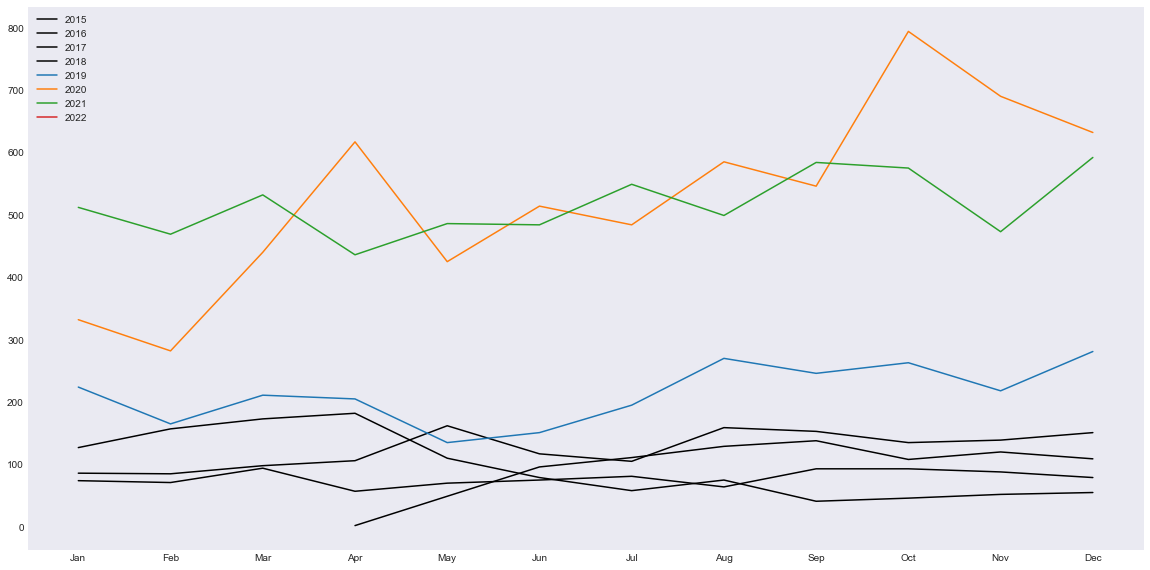

In [496]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

# plotting for each year, by month
# years prior to, and including, 2019
years = [2015, 2016, 2017, 2018]
i = 0
for year in years:
    sub = monthly_tickets[monthly_tickets['year'] == year]
    ax.plot(sub['month'], sub['number_of_tickets'], label=year, c='black')
    i += 1

# years of 2019 to present    
years = [2019,2020, 2021, 2022]
i = 0
for year in years:
    sub = monthly_tickets[monthly_tickets['year'] == year]
    ax.plot(sub['month'], sub['number_of_tickets'], label=year)
    i += 1    

    
# x-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

# legend
ax.legend(loc="upper left")
    
plt.style.use('seaborn-dark')     
plt.show()

# Unique visitors - BST

In [514]:
'''
Reverse earlier code that set 'creator_user_id' to a string. 
We need to use the numbers themselves in order to organize them within a BST.
'''

df['creator_user_id'] = df['creator_user_id'].astype(int)

In [515]:
# Create a BST
# Code pulled from https://qvault.io/python/binary-search-tree-in-python/ and https://qvault.io/python/binary-search-tree-in-python/

class BSTNode:
    def __init__(self, val=None):
        self.left = None
        self.right = None
        self.val = val
        
    # Insert value into tree
    def insert(self, val):
        if not self.val:
            self.val = val
            return

        if self.val == val:
            return

        if val < self.val:
            if self.left:
                self.left.insert(val)
                return
            self.left = BSTNode(val)
            return

        if self.right:
            self.right.insert(val)
            return
        self.right = BSTNode(val)
    
    
    
    # Check if value exists in tree
    def exists(self, val):
        if self.val is None:
            return
        
        if val == self.val:
            return True

        if val < self.val:
            if self.left == None:
                return False
            return self.left.exists(val)

        if self.right == None:
            return False
        return self.right.exists(val)
    
# Print the tree in a horizontal-moving shape
def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '->', node.val)
        printTree(node.right, level + 1)

In [516]:
'''
Cycle through each ID and add to the BST
If the ID exists, that will be a repeat visitor
If the ID does NOT exist, it is a unique visitor.
If it is a unique visitor, incriment +1 for the respective Month, Year
'''

# Reverse the df so that the earliest case is at the beginning
df_rev = df.iloc[::-1]

# Initialize the lists and the tree
unique_ID = []
unique_date = []
bst = BSTNode()

# For each row within the reversed df (beginning 2015)
for index, row in df_rev.iterrows():
    # If the submitter ID does NOT exist, it is assumed to be unique
    if bst.exists(row[1]) == False:
        # Therefore, append each of the tables unique_date and unique_ID with the creation date of the ticket and user ID, respectively
        unique_date.append(row[5].date())
        unique_ID.append(row[1])
    # Finally, insert the user ID into the BST so that it won't be double-counted as unique    
    bst.insert(row[1])


# Add the two lists from above into a DF
x = pd.Series(unique_date)
y = pd.Series(unique_ID)
headers = ['unique_date','unique_ID']
df_unique = pd.concat([x,y], axis=1, keys=headers)

# Return the user_ID type into a string
df['creator_user_id'] = df['creator_user_id'].astype(str)

In [517]:
df_unique

,unique_date,unique_ID
0,2015-06-05,1024098
1,2015-06-05,1329385
2,2015-06-05,3050855
3,2015-06-05,7586111
4,2015-06-06,57258
...,...,...
4222,2022-01-07,23327515
4223,2022-01-07,47019599
4224,2022-01-07,64261155
4225,2022-01-07,68482867


In [518]:
df_unique['year'] = df_unique.unique_date.apply(lambda x: x.year)
df_unique['month'] = df_unique.unique_date.apply(lambda x: x.month)

In [519]:
monthly_unique = (df_unique.groupby([df_unique.year, df_unique.month])
           .size()
           .rename_axis(index=['year', 'month'],)
           .reset_index())

monthly_unique.columns.values[2] = "number_of_unique_visitors"
monthly_unique

,year,month,number_of_unique_visitors
0,2015,6,28
1,2015,7,23
2,2015,8,33
3,2015,9,29
4,2015,10,25
...,...,...,...
75,2021,9,126
76,2021,10,135
77,2021,11,109
78,2021,12,88


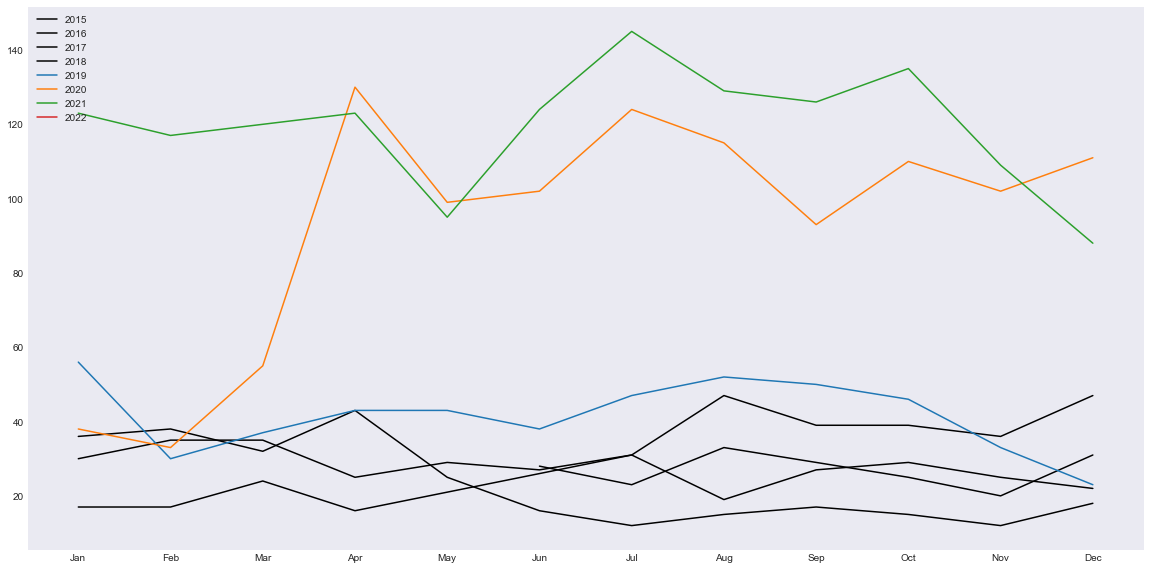

In [520]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))


# plotting for each year, by month
# years prior to, and including, 2019
years = [2015, 2016, 2017, 2018]
i = 0
for year in years:
    sub = monthly_unique[monthly_unique['year'] == year]
    ax.plot(sub['month'], sub['number_of_unique_visitors'], label=year, c='black')
    i += 1


# years of 2019 to present    
years = [2019,2020, 2021, 2022]
i = 0
for year in years:
    sub = monthly_unique[monthly_unique['year'] == year]
    ax.plot(sub['month'], sub['number_of_unique_visitors'], label=year)
    i += 1    
    
# x-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

# legend
ax.legend(loc="upper left")

plt.style.use('seaborn-dark')    
plt.show()

Insights:
* Number of unique users held steady each year for the 2015 to 2019 period.
* March of 2020, **something** happened to the community - the level of unique users submitting tickets rose sharply, from ~55 to ~130  users for the month of March.
* Since that period, the levels of unique users has continued to be maintained.
* Assumptions as to why the levels rose drastically can be due to COVID, as the pandemic also began March 2020.
* > The reasoning behind this spike required further digging. I'd look into the number of enterprises utilizing Apache Airflow, as an influx of large corporations could also influence the large spike in activity.

# Length of time for a ticket to close

In [499]:
# Create a DF containing open date and number of days closed
df_days = df[['created_date','time_to_close']]

# Remove tickets that have yet to be closed
df_days = df_days[df_days['time_to_close'] != 'Not Closed']

# Changing day values to int
df_days['time_to_close'] = df_days['time_to_close'].astype(int)

In [500]:
df_days

,created_date,time_to_close
0,2022-01-08,0
2,2022-01-08,0
10,2022-01-07,0
14,2022-01-07,0
15,2022-01-07,0
...,...,...
19663,2015-06-05,2
19664,2015-06-05,0
19665,2015-06-05,12
19666,2015-04-20,0


####  Average time for a ticket to close since 2015

In [501]:
df_days.time_to_close.mean()

40.40587606837607

This seams awfully long (over a month for a ticket to close is a very long time). Since we took the mean, let's check the median time.

In [502]:
from statistics import mode

print("The median is", df_days.time_to_close.median())
print("The mode is", mode(df_days.time_to_close))

The median is 1.0
The mode is 0


Median number of days is one and the mode is zero, which implies that most tickets are solved fairly quickly (by the next day). The mean is, therefore, influenced by a number of outliers. Let's find and eliminate them.

### Looking at outliers for the number of days a ticket has been opened for

In [503]:
df_days.time_to_close.value_counts()

0       6644
1       2939
2       1141
3        710
4        532
        ... 
810        1
736        1
203        1
472        1
1733       1
Name: time_to_close, Length: 654, dtype: int64

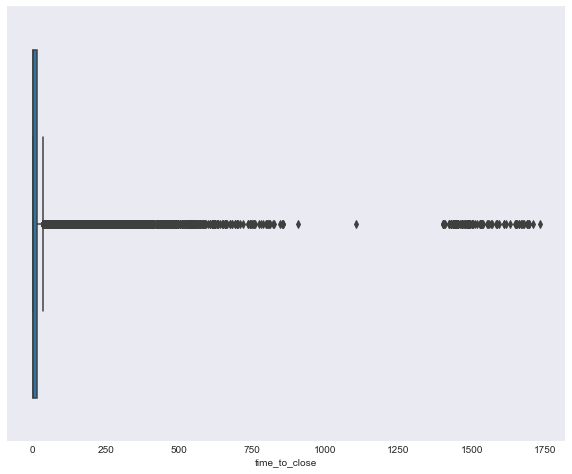

In [504]:
# Box plot to look at the number of days a ticket has been opened for.
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x=df_days.time_to_close)
plt.show()

In [505]:
df_days.time_to_close.describe()

count    18720.000000
mean        40.405876
std        144.314739
min          0.000000
25%          0.000000
50%          1.000000
75%         14.000000
max       1733.000000
Name: time_to_close, dtype: float64

### Removing outliers

In [507]:
drop_numerical_outliers(df_days)

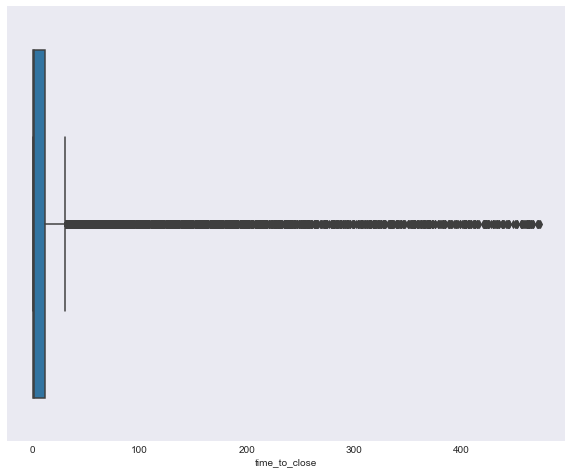

In [508]:
# Box plot to look at the number of days a ticket has been opened for.
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x=df_days.time_to_close)
plt.show()

In [509]:
df_days.time_to_close.describe()

count    18420.000000
mean        25.650977
std         65.006554
min          0.000000
25%          0.000000
50%          1.000000
75%         12.000000
max        473.000000
Name: time_to_close, dtype: float64

### Analyzing Ticket Completion Time

In [510]:
df_days['year'] = df_days.created_date.apply(lambda x: x.year)
df_days['month'] = df_days.created_date.apply(lambda x: x.month)

In [511]:
monthly_ticket_time = (df_days.groupby([df_days.year, df_days.month])
           .agg(number_of_tickets=('time_to_close', 'size'), average_time_total=('time_to_close', 'mean'))
           .reset_index())


monthly_ticket_time['average_time_total'] = round(monthly_ticket_time['average_time_total'],2)
monthly_ticket_time

,year,month,number_of_tickets,average_time_total
0,2015,4,2,0.00
1,2015,6,95,6.32
2,2015,7,107,10.57
3,2015,8,121,22.46
4,2015,9,132,27.33
...,...,...,...,...
76,2021,9,531,8.02
77,2021,10,501,9.15
78,2021,11,390,5.78
79,2021,12,474,3.46


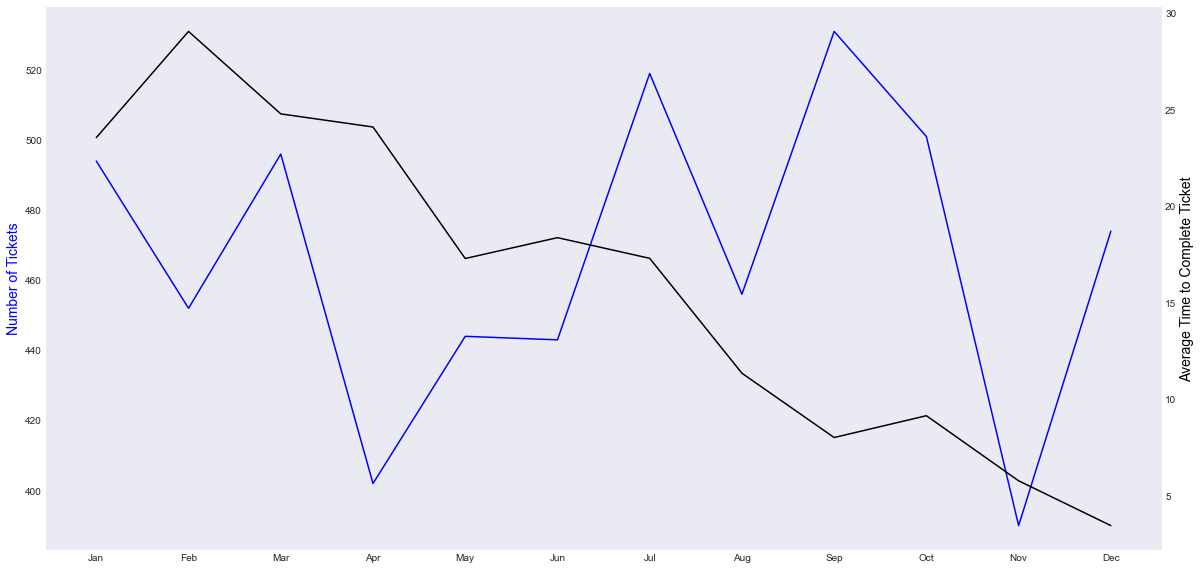

In [512]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))


sub = monthly_ticket_time[monthly_ticket_time['year'] == 2021]
ax.plot(sub['month'], sub['number_of_tickets'], label=2021, c = 'blue')
ax.set_ylabel("Number of Tickets",color="blue",fontsize=14)

ax2=ax.twinx()
sub2 = monthly_ticket_time[monthly_ticket_time['year'] == 2021]
ax2.plot(sub2['month'], sub2['average_time_total'], label=2021, c = 'black')
ax2.set_ylabel("Average Time to Complete Ticket",color="black",fontsize=14)   
    
# x-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

plt.style.use('seaborn-dark')    
plt.show()

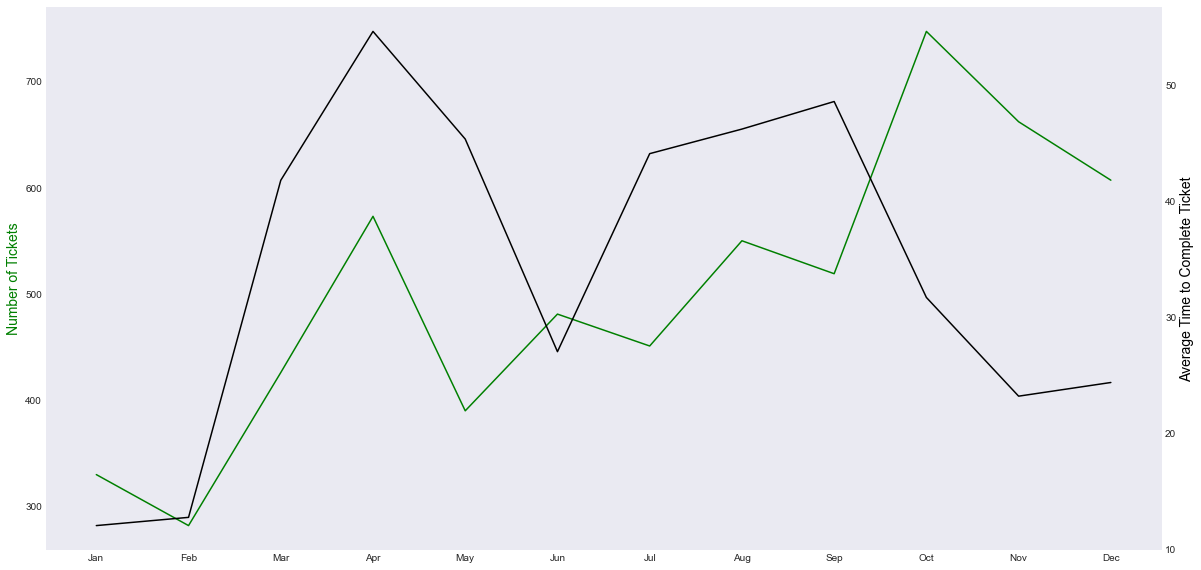

In [513]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))


sub = monthly_ticket_time[monthly_ticket_time['year'] == 2020]
ax.plot(sub['month'], sub['number_of_tickets'], label=2020, c = 'green')
ax.set_ylabel("Number of Tickets",color="green",fontsize=14)

ax2=ax.twinx()
sub2 = monthly_ticket_time[monthly_ticket_time['year'] == 2020]
ax2.plot(sub2['month'], sub2['average_time_total'], label=2020, c = 'black')
ax2.set_ylabel("Average Time to Complete Ticket",color="black",fontsize=14)
    
# x-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

plt.style.use('seaborn-dark')    
plt.show()

## Step X: Removing Outliers from Numerical Columns with Z-Score Method

In [521]:
df_cleaned = df.copy()

In [522]:
drop_numerical_outliers(df_cleaned)

In [523]:
df_cleaned.describe()

,comments,length_of_title,length_of_body,n_labels
count,18886.000000,18886.000000,18886.000000,18886.000000
mean,3.462035,50.322514,1367.132532,1.190088
std,3.674687,16.716960,1144.578102,1.217766
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,39.000000,648.250000,0.000000
50%,2.000000,50.000000,1247.000000,1.000000
75%,5.000000,61.000000,1700.000000,2.000000
max,20.000000,106.000000,9642.000000,5.000000


Distribution before outlier removal:

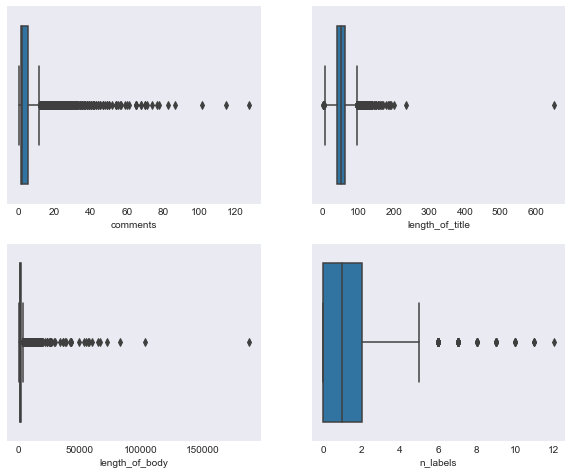

In [524]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(ax=ax[0,0], x=df.comments)
sns.boxplot(ax=ax[0,1], x=df.length_of_title)
sns.boxplot(ax=ax[1,0], x=df.length_of_body)
sns.boxplot(ax=ax[1,1], x=df.n_labels)

plt.show()

Distribution **after** outlier removal:

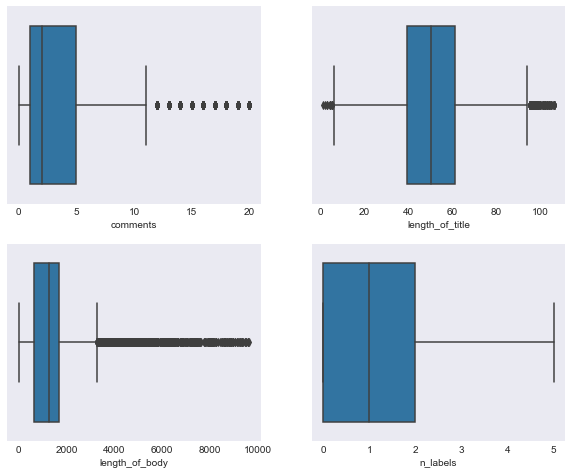

In [525]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(ax=ax[0,0], x=df_cleaned.comments)
sns.boxplot(ax=ax[0,1], x=df_cleaned.length_of_title)
sns.boxplot(ax=ax[1,0], x=df_cleaned.length_of_body)
sns.boxplot(ax=ax[1,1], x=df_cleaned.n_labels)

plt.show()

Text(0, 0.5, 'Number of Labels')

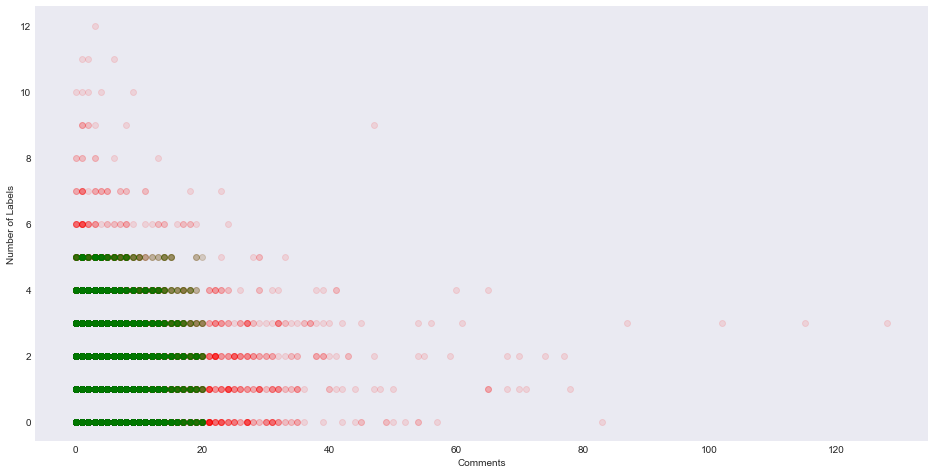

In [526]:
fig, ax = plt.subplots(figsize=(16,8))

x = df_cleaned.comments
y = df_cleaned.n_labels

x2 = df.comments
y2 = df.n_labels

plt.scatter(x2, y2, alpha=0.1, c='red')
plt.scatter(x, y, alpha=0.1, c='green')


plt.xlabel('Comments')
plt.ylabel('Number of Labels')

# Predictive Machine Learning

In [527]:
# '''
# Now that we understand our data better, let's see if we can predict 
# whether or not an issue is closed given other attributes.
# Should we treat all issues created over the years the same?

# We notice that the classes are not balanced. Probably a good idea to address that.
# '''
# df.state.value_counts()

In [528]:
# '''
# Which of the features above should we include in our ML model?

# The title and body are great text features which we could do some NLP on, but maybe later.
# '''
# def split_features_and_target(df, features_ml=None):
#     target = df.state
#     df.drop([c for c in df if c not in features_ml], axis=1, inplace=True)
#     return df, target


# features_ml, target = split_features_and_target(
#     df,
#     features_ml = [
#     # List of features to use for ML
#     ]
# )

# features_ml

In [529]:
# Split the data for training and testing


In [530]:
# Load in a model and train it


In [531]:
# Evaluate the model on the test data


In [532]:
# Plot the receiver operating characteristic curve and include the area under the curve


# Dead tickets?

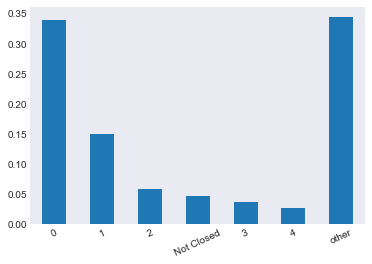

In [497]:
'''
Let's look at 'dead' tickets: ones open for more than, lets say
'''

# length = dict(df.creator_user_id.value_counts(normalize=True).loc[lambda x : x>0.0005]) 

prob = df.time_to_close.value_counts(normalize=True)
threshold = 0.02
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

In [498]:
df.author_association.value_counts()

CONTRIBUTOR     8997
MEMBER          7035
NONE            3587
COLLABORATOR      10
Name: author_association, dtype: int64